In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
# Load trader data
trader_df= pd.read_csv(r"..\PrimeTrade\dataset\historical_data.csv")

# Load sentiment data
sentiment_df= pd.read_csv(r"..\PrimeTrade\dataset\fear_greed_index.csv")

In [5]:
#inspecting trader data
print(trader_df.head())
print(trader_df.info())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [6]:
#inspecting sentiment data
print(sentiment_df.head())
print(sentiment_df.info())

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None


Cleaning data

In [11]:
# Convert trader time column to datetime
trader_df['Timestamp IST']= pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Convert sentiment date column to datetime
sentiment_df['date']= pd.to_datetime(sentiment_df['date'], format='%d-%m-%Y')

In [12]:
#creating date only column in trader 
trader_df['date_only']= trader_df['Timestamp IST'].dt.date
trader_df['date_only']= pd.to_datetime(trader_df['date_only'])

In [13]:
#merging data of both trader and sentiment dataset
merged_df= pd.merge(trader_df, sentiment_df, left_on='date_only', right_on='date', how='left')

We group and aggregate to transform raw trade-level data into daily trader-level summaries, so we can clearly compare behaviors across sentiments.

In [15]:
#Create daily metrics per trader
daily_metrics= merged_df.groupby(['Account', 'date_only', 'classification']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Size Tokens': 'sum',
    'Transaction Hash': 'count'}).reset_index()

daily_metrics= daily_metrics.rename(columns={'Transaction Hash': 'num_trades'})

Distribution of daily PnL by sentiment

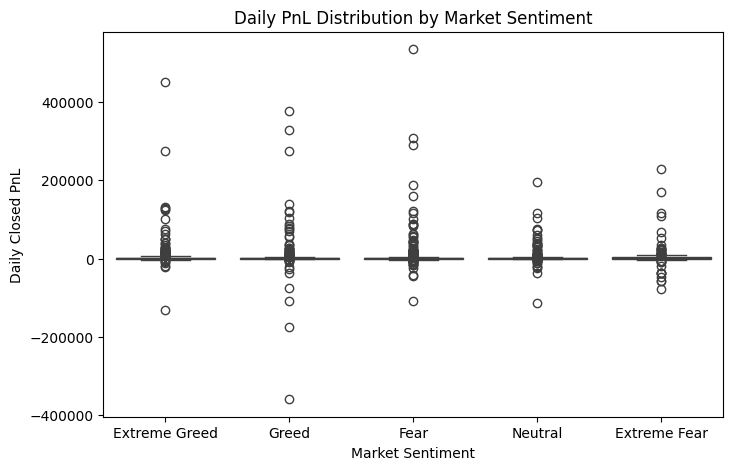

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(data= daily_metrics, x='classification', y='Closed PnL')
plt.title('Daily PnL Distribution by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Daily Closed PnL')
plt.show()

Distribution of number of trades by sentiment

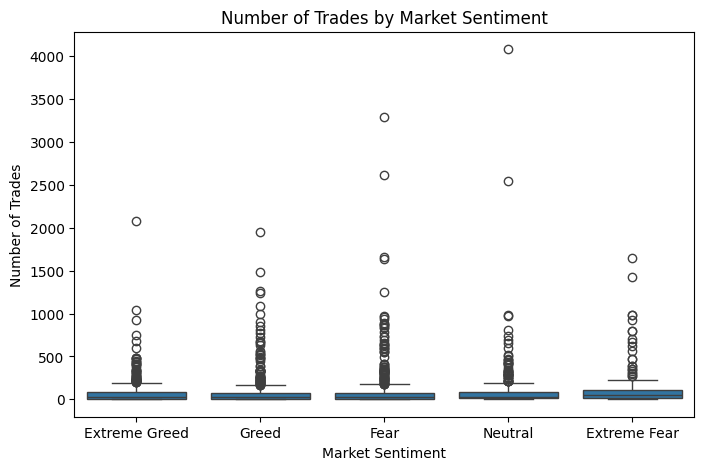

In [17]:
plt.figure(figsize=(8,5))
sns.boxplot(data= daily_metrics, x='classification', y='num_trades')
plt.title('Number of Trades by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Number of Trades')
plt.show()

Distribution of total USD position size by sentiment

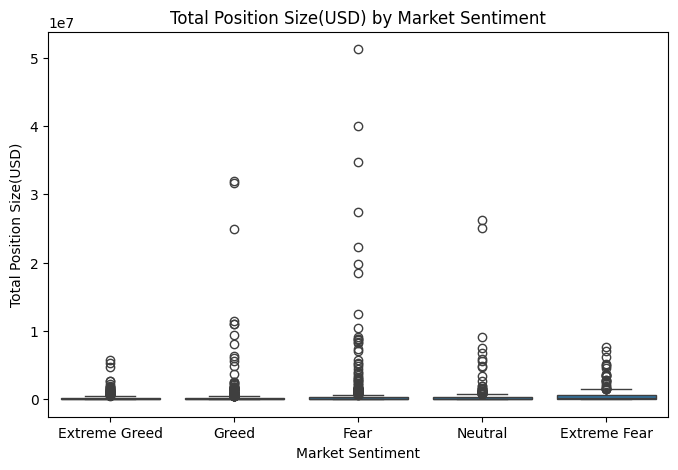

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(data= daily_metrics, x='classification', y='Size USD')
plt.title('Total Position Size(USD) by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Position Size(USD)')
plt.show()

Explore top 10 traders' PnL by sentiment

In [26]:
top_accounts= daily_metrics.groupby('Account')['Closed PnL'].sum().sort_values(ascending=False).head(10).index
top_df= daily_metrics[daily_metrics['Account'].isin(top_accounts)]

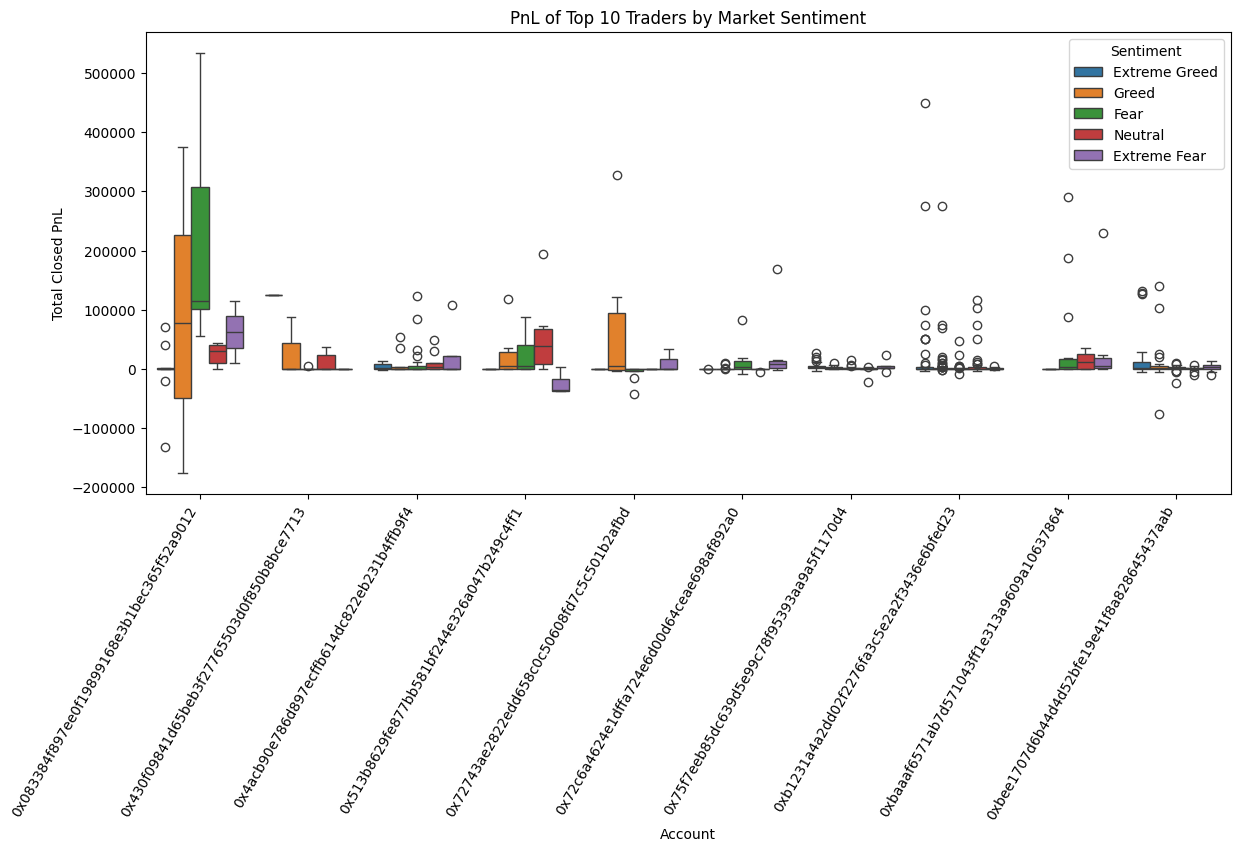

In [33]:
plt.figure(figsize=(14,6))
sns.boxplot(data= top_df, x='Account', y='Closed PnL', hue='classification')
plt.title('PnL of Top 10 Traders by Market Sentiment')
plt.xticks(rotation=60, ha='right')
plt.xlabel('Account')
plt.ylabel('Total Closed PnL')
plt.legend(title='Sentiment')
plt.show()

Insights

- PnL tends to be higher during "Greed" periods, suggesting traders capture more upside moves and actively exploit momentum.
- The number of trades and position sizes are also higher during "Greed", reflecting greater risk appetite and confidence.
- Top traders show a strong positive PnL during "Greed", indicating they are skilled at riding bullish momentum and scaling positions effectively.
- During "Fear", more conservative behavior is observed (fewer trades and smaller positions). However, some traders still achieve positive PnL, highlighting opportunities for selective or contrarian strategies even in bearish sentiment.

Recommendations

- Align trading aggressiveness with market sentiment, which increase position sizes and trade frequency during "Greed", but maintain strict risk and stop-loss controls.
- During "Fear", focus on selective, high-conviction trades or mean-reversion approaches rather than aggressive momentum chasing.
- Integrate real-time sentiment monitoring into daily trading decisions to dynamically adapt strategies and improve risk-adjusted returns.